/var/folders/mc/hlssmgzx3tl9sy5vfz_20m980000gn/T/ipykernel_43070/1476823141.py:33: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['DATE'] = pd.to_datetime(df['DATE'])


Epoch 0, Loss: nan
Epoch 10, Loss: nan
Epoch 20, Loss: nan
Epoch 30, Loss: nan
Epoch 40, Loss: nan
Epoch 50, Loss: nan
Epoch 60, Loss: nan
Epoch 70, Loss: nan
Epoch 80, Loss: nan
Epoch 90, Loss: nan
Date: 2018-06-03T00:00:00.000000000, Forecasted Value: nan
Date: 2018-07-03T00:00:00.000000000, Forecasted Value: nan
Date: 2018-08-02T00:00:00.000000000, Forecasted Value: nan
Date: 2018-09-01T00:00:00.000000000, Forecasted Value: nan
Date: 2018-10-01T00:00:00.000000000, Forecasted Value: nan
Date: 2018-10-31T00:00:00.000000000, Forecasted Value: nan
Date: 2018-11-30T00:00:00.000000000, Forecasted Value: nan
Date: 2018-12-30T00:00:00.000000000, Forecasted Value: nan
Date: 2019-01-29T00:00:00.000000000, Forecasted Value: nan
Date: 2019-02-28T00:00:00.000000000, Forecasted Value: nan
Date: 2019-03-30T00:00:00.000000000, Forecasted Value: nan
Date: 2019-04-29T00:00:00.000000000, Forecasted Value: nan
Date: 2019-05-29T00:00:00.000000000, Forecasted Value: nan
Date: 2019-06-28T00:00:00.00000000

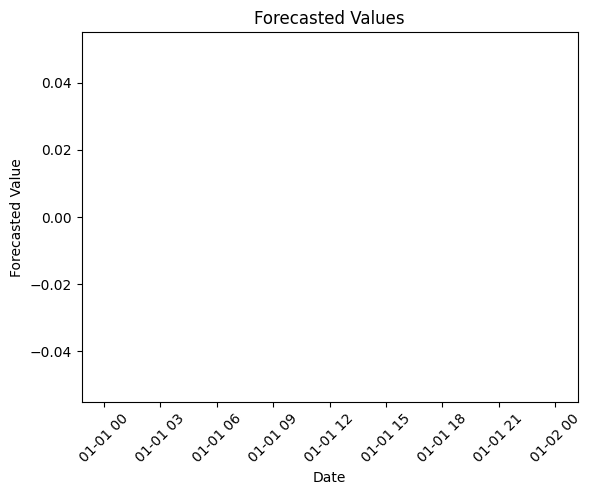

In [28]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import GCNConv
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

# Define ST-GNN model
class STGNN(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, num_layers, dropout):
        super(STGNN, self).__init__()
        self.convs = nn.ModuleList()
        self.convs.append(GCNConv(in_channels, hidden_channels))
        for _ in range(num_layers - 1):
            self.convs.append(GCNConv(hidden_channels, hidden_channels))
        self.lin = nn.Linear(hidden_channels, out_channels)
        self.dropout = dropout

    def forward(self, x, edge_index):
        for conv in self.convs:
            x = conv(x, edge_index)
            x = torch.relu(x)
            x = nn.Dropout(self.dropout)(x)
        x = self.lin(x)
        return x

# Load data from CSV
def load_data(file_path):
    df = pd.read_csv(file_path)
    df['DATE'] = pd.to_datetime(df['DATE'])
    df.sort_values(by='DATE', inplace=True)
    
    # Extract features and target variable
    coords = df[['LON', 'LAT']].values
    dates = df['DATE'].values
    variable = df['DISSOLVED_OXYGEN_MG_L'].values

    # Normalize coordinates and variable
    coords = (coords - coords.mean(axis=0)) / coords.std(axis=0)
    variable = (variable - variable.mean()) / variable.std()
    
    # Create temporal features (time differences in days)
    start_date = dates.min()
    temporal_features = [(d - start_date).astype('timedelta64[D]').astype(int) for d in dates]
    temporal_features = np.array(temporal_features).reshape(-1, 1)

    # Combine spatial and temporal features
    x = np.hstack((coords, temporal_features))
    y = variable

    return x, y, dates, coords

# Create edges for the graph
def create_edges(coords):
    from scipy.spatial import Delaunay

    tri = Delaunay(coords)
    edges = set()
    for simplex in tri.simplices:
        for i, j in zip(simplex, simplex[[1, 2, 0]]):
            edges.add(tuple(sorted((i, j))))
    edge_index = torch.tensor(list(edges), dtype=torch.long).t().contiguous()
    return edge_index

# Prepare data for PyTorch Geometric
def prepare_data(file_path):
    x, y, dates, coords = load_data(file_path)
    edge_index = create_edges(coords)
    data = Data(x=torch.tensor(x, dtype=torch.float), 
                edge_index=edge_index, 
                y=torch.tensor(y, dtype=torch.float))
    return data, dates

# Train the model
def train_model(data, epochs=100, lr=0.01, hidden_channels=16, num_layers=2, dropout=0.5):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = STGNN(data.num_node_features, hidden_channels, 1, num_layers, dropout).to(device)
    data = data.to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()

    model.train()
    for epoch in range(epochs):
        optimizer.zero_grad()
        out = model(data.x, data.edge_index)
        loss = criterion(out.squeeze(), data.y)
        loss.backward()
        optimizer.step()
        if epoch % 10 == 0:
            print(f'Epoch {epoch}, Loss: {loss.item()}')
    
    return model

# Forecast function
def forecast(model, data, last_date, forecast_years=5):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.eval()
    with torch.no_grad():
        data = data.to(device)
        out = model(data.x, data.edge_index)
        # Generate future dates for the forecast
        forecast_dates = [last_date + np.timedelta64(30 * i, 'D') for i in range(0, 12 * forecast_years)]
        # Using the model's predictions for these future dates
        forecast_values = out.squeeze().cpu().numpy()[:len(forecast_dates)]
    return forecast_dates, forecast_values

# Main function to load data, train model, and forecast
def main(file_path):
    data, dates = prepare_data(file_path)
    model = train_model(data)
    forecast_dates, forecast_values = forecast(model, data, dates[-1])
    return forecast_dates, forecast_values

# Example usage
file_path = '/Users/emilyzhao/li-sound/.streamlit/data/processed/processed-surface.csv'
forecast_dates, forecast_values = main(file_path)

# Print forecasted values
for date, value in zip(forecast_dates, forecast_values):
    print(f'Date: {date}, Forecasted Value: {value}')

plt.plot(forecast_dates, forecast_values)
plt.xlabel('Date')
plt.ylabel('Forecasted Value')
plt.title('Forecasted Values')
plt.xticks(rotation=45)
plt.show()